<a href="https://colab.research.google.com/github/KostaLip/PPPO_Projekat_IT31_2021/blob/main/PPPO_Kosta_Bjelogrlic_IT31_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PRINCIPI PREZENTACIJE I PREPOZNAVANJA OBLIKA 2024/2025**

Kosta Bjelogrlić IT31-2021  
Tema: Segmentacija soli

**SADRŽAJ PROJEKTA**



1.   Uvod
2.   Segmentacija soli
3.   Korišćene tehnologije
4.   Analiza koda i modela
5.   Testiranje modela
6.   Zaključak
7.   Izvori i literatura


**Uvod**

Segmentacija slike predstavlja podjelu slike na različite regione ili kategorije, pri čemu svaka regija sadrži piksele sa sličnim atributima, a svaki piksel na fotografiji dodjeljuje se jednoj od kategorija.
Segmentacija fotografije se obično koristi radi pojednostavljivanja predstavljanja fotografije u segmentima koji su značajniji i mnogo lakši za analizu. Ako je segmentacija dobro izvedena, onda su sve druge faze u analizi fotografije pojednostavljene, što znači da kvalitet segmentacije diktiraju da li će analiza fotografije biti uspješna. Podjela fotografije na ispravne segmente često je vrlo izazovan problem, pogotovo ukoliko je dataset fotografija mali i ukoliko je kvalitet fotografija slab.  
Funkcioniše tako što model prvo dobije sliku pa kroz mrežu uči da prepozna obrasce kao što su ivice, oblici i teksture. Zatim kroz dekoderski dio mreže pokušava da od tih informacija napravi masku, tj. novu sliku gdje je označeno koji dio pripada objektu. Na kraju dobijamo masku iste veličine kao originalna slika, ali u kojoj svaki piksel nosi informaciju o klasi. Segmentacija ima široku primjenu u medicini, automobilskoj industriji, satelitskim snimcima, seizmološkim snimcima itd.

**Segmentacija soli**

Segmentacija soli predstavlja specifičanu primjenu segmentacije, gdje cilj nije prepoznavanje klasičnih objekata poput pasa ili auta, već za cilj ima prepoznavanje složenih obrazaca u seizmološkim snimcima. Osnovni zadatak segmentacije soli jeste da prepozna gdje se u seizmološkim snimcima nalaze slojevi soli. Segmentacija soli kao ulaz prima sliku odnosno seizmološki snimak, kojeg model dalje analizira i uočava obrazce i teksture na slici, i na kraju dava masku koja nam govori gdje se na slici nalazi so a gdje ne. Pikseli maske koji su označeni sa 1 predstavljaju dio slike na kome se nalazi so, a 0 predstavlja dio slike gdje se ne nalazi so.

**Korišćene tehnologije**

U ovom projektu korišćena je kombinacija biblioteka za duboko učenje *TensorFlow* i *Keras*. Za obradu slika i za njihovu promjenu veličina i za normalizaciju slika korišćeni su *OpenCV* i *NumPy*, dok se za analizu podataka koristi *MatplotLib*.  
Što se tiče dobijenog dataseta za projekat, dataset ima dosta slika, međutim dosta tih slika su duplikati u folderima *train.zip*, *flamingo.zip*, *competition_data.zip* jer sadrže identične foldere sa slikama i maskama (*images* i *masks*). Zato ćemo ovdje koristiti samo taj *train.zip* folder sa njegovim *images* i *masks* folderima. Kada je riječ o testnim podacima odnosno podacima za evaluaciju, tu imamo folder test ali samo sa slikama bez maski. Tako da se te slike mogu samo koristiti za direktne predikcije bez uvida u stvarnu masku te slike. Zato ćemo morati podatke iz *train.zip* podjeliti na podatke za učenje, validaciju i evaluaciju.

**Analiza koda i modela**

Zbog bržeg prenošenja podataka samim tim učenja i evaluacije modela i zbog određenih problema sa *drive*-om ovdje smo direktno importovali *train.zip* folder u *Colab*. Prvo provjeravamo da li je on već unzip-ovan i ukoliko nije onda ga unzip-ujemo. Naravno prethodno moramo importovati neophodne biblioteke.

In [1]:
import zipfile
import os
if os.path.exists('/content/trainExtr'):
  print('Folder train.zip je vec unzipovan')
else:
  print('Unzipovanje foldera train.zip')
  with zipfile.ZipFile('train.zip', 'r') as zipRef:
    zipRef.extractall('trainExtr')

Unzipovanje foldera train.zip


Već sada ćemo da postavimo neophodne vrijednosti za *seed*, odnosno fiksnu vrijednost za sve generatore slučajnih brojeva, koje ćemo poslije koristiti kako bi smo dobijali stabilne i slične rezultate svaki put kada pokrećemo kod.

In [2]:
import numpy as np
import random
import tensorflow as tf
seed=2019
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
def getSeed():
  return seed

Dalje implementiramo funkcije koje ćemo koristiti za dobijanje putanja za slike i maske iz ekstraktovanog *trainExtr* foldera. Ovdje ćemo takođe i sortirati putanje slika i njima odgovarajućih maska kako bi smo osigurali da se svaka slika uparuje sa svojom odgovarajućom *ground truth* maskom. To postižemo tako što ćemo putanje sortirati po nazivu konkretnih slika i maska koje dobijamo uz pomoć *os.path.basename* funkcije.

In [3]:
import glob
def getAllImagePaths():
  allImages = glob.glob('/content/trainExtr/images/*.png', recursive=True)
  return sorted(allImages, key=lambda x: os.path.basename(x))

In [4]:
def getAllMaskPaths():
  allMasks = glob.glob('/content/trainExtr/masks/*.png', recursive=True)
  return sorted(allMasks, key=lambda x: os.path.basename(x))

Sledeće što je urađeno jeste da smo logiku dobijanja konkretnih slika razbili u više funkcija gdje u *getAllImages* prvo dobijamo putanje za sve slike i zatim za svaku putanju pozivamo *getImage* koji će da nam vrati konkretnu sliku sa te putanje. *loadImage* će takođe da resize-uje sliku na *128,128* i da je metodom *img_to_array* pretvori u format koji koristi *TensorFlow*. Tu smo koristili *cv2* jer je efikasan za jednostavene operacije sa sliakama kao što je *resize* i time pravimo kompromis između kvaliteta slike i brzine treninga. Kada funkcija *getAllImages* dobije tu sliku ona će da je normalizuje, odnosno normalizovaće vrijednosti piksela između 0 i 1 jer neuronske mreže bolje konvergiraju kada su input vrijednosti u malom opsegu, i da vrati sve slike. Analogno i za maske samo što prvo moramo da sve piksele koji su veći od 0 da pretvorimo u 1 i da im dodamo dodatni kanal jer neuronske mreže očekuju da sve slike i maske imaju oblik sa kanalom.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
def loadImage(imagePath, show=False):
  image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
  imageResize = cv2.resize(image, (128,128))
  imageTensor = img_to_array(imageResize)
  return imageTensor

In [6]:
def loadMask(maskPath, show=False):
  mask = cv2.imread(maskPath, cv2.IMREAD_GRAYSCALE)
  maskResize = cv2.resize(mask, (128, 128))
  maskResize = (maskResize>0).astype(np.uint8)
  maskTensor = np.expand_dims(maskResize, axis=-1)
  return maskTensor

In [7]:
def getAllImages():
  data = [];
  filePaths = getAllImagePaths()
  filePaths.sort()

  for imagePath in filePaths:
    image = loadImage(imagePath)
    image = image /255.0
    data.append(image)
  return np.array(data)

In [8]:
def getAllMasks():
  filePaths = getAllMaskPaths()
  data = []
  filePaths.sort()
  for maskPath in filePaths:
    mask = loadMask(maskPath)
    data.append(mask)
  return np.array(data)

Nakon toga kreiramo setove podataka za treniranje, validaciju i evaluaciju. Ostavljamo što veći broj podataka za učenje jer broj slika nije baš veliki i želimo da ih imamo što više za treniranje ali i dovoljno za validaciju za normalno praćenje metrika (*test_size*=0.13). Zatim smo mali dio podataka iz podataka za validaciju smjestili u podatke za evaluaciju (*test_size*=0.23). Metoda koju smo koristili za podjelu podataka je *train_test_split*.

In [10]:
from sklearn.model_selection import train_test_split
x = getAllImages()
y = getAllMasks()

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.13, random_state=getSeed())
xVal, xEval, yVal, yEval = train_test_split(xTest, yTest, test_size=0.23, random_state=getSeed())
print(f"Trening set Slike: {xTrain.shape}, Maske: {yTrain.shape}")
print(f"Set za validaciju Slike: {xVal.shape}, Masek: {yVal.shape}")
print(f"Set za evaluaciju Slike: {xEval.shape}, Makse: {yEval.shape}")

Trening set Slike: (3480, 128, 128, 1), Maske: (3480, 128, 128, 1)
Set za validaciju Slike: (400, 128, 128, 1), Masek: (400, 128, 128, 1)
Set za evaluaciju Slike: (120, 128, 128, 1), Makse: (120, 128, 128, 1)


Sledeće što radimo jeste da definišemo *U-Net* model. On se sastoji iz 2 dijela:
1.   *encoder* - koji spušta sliku i uči globalne osobine
2.   *decoder* - koji zatim diže sliku na punu rezoluciju i rekonstruiše masku  

*U-Net* model je idealan za segmentaciju jer kombinuje kontekstualnu informaciju iz dubljih slojeva i lokalne detalje iz skip konekcija.  

In [ ]:
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, MaxPooling2D, GlobalMaxPool2D, Conv2D, Conv2DTranspose, concatenate, add
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
def unetModel(inputSize=(128,128, 1)):
  inputs=Input(inputSize)
  c1= Conv2D(64, 3, activation='relu', padding='same')(inputs)
  c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
  p1 = MaxPooling2D(pool_size=(2,2))(c1)

  c2 = Conv2D(128, 3,activation='relu', padding='same')(p1)
  c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
  p2 = MaxPooling2D(pool_size=(2, 2))(c2)
  c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
  c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
  p3 = MaxPooling2D(pool_size=(2, 2))(c3)
  deep = Conv2D(512, 3, activation='relu', padding='same')(p3)
  deep = Conv2D(512, 3, activation='relu', padding='same')(deep)

  up5 = Conv2DTranspose(256, 2, strides=(2,2), padding='same')(deep)
  merge5 = concatenate([c3, up5], axis=3)
  conv5 =Conv2D(256,3, activation='relu', padding='same')(merge5)
  conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
  up6 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
  merge6 = concatenate([c2, up6], axis=3)
  conv6 =Conv2D(128, 3, activation='relu', padding='same')(merge6)
  conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

  up7 = Conv2DTranspose(64, 2, strides=(2,2), padding='same')(conv6)
  merge7 = concatenate([c1, up7], axis=3)
  conv7 = Conv2D(64, 3, activation='relu', padding='same')(merge7)
  conv7 = Conv2D(64,3, activation='relu', padding='same')(conv7)

  conv8 = Conv2D(1, 1, activation='sigmoid')(conv7)
  model =Model(inputs=inputs, outputs=conv8)
  return model

Kako model ne bi učio stalno na istim slikama vrši se njihova augmentacija. To znači da tokom testiranja vršimo njihovu nasumičnu transformaciju (rotiramo, okrećemo, zumiramo...). Na taj način naš model postaje otporniji i bolje generalizuje. Umjesto da sve podatke učita odjednom, funkcija *trainGenerator* nam vraća samo određeni broj po *batch*-evima(32).

In [ ]:
imageAug = ImageDataGenerator(rotation_range = 10,width_shift_range = 0.1, height_shift_range=0.1,zoom_range=0.1, horizontal_flip=True)
maskAug = ImageDataGenerator(rotation_range = 10, width_shift_range = 0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)
imageAug.fit(xTrain, augment=True, seed=getSeed())
maskAug.fit(yTrain, augment=True, seed=getSeed())

def trainGenerator(batch_size):
  imageGenerator = imageAug.flow(xTrain, batch_size=batch_size, seed=seed)
  maskGenerator = maskAug.flow(yTrain, batch_size=batch_size, seed=seed)
  while True:
    xBatch = next(imageGenerator)
    yBatch = next(maskGenerator)
    yield xBatch,yBatch

Kreirali smo i dvije metrike *binary_iou_metric* i *dice_coefficient* koje mjere koliko se predviđena maska poklapa sa stvarnom maskom. One će nam predstavljati mjeru uspješnosti modela.  
*IoU* mjeri preklapanje između stvarne i predviđene makse, dok je *Dice* sličan ali daje više značaj preklapanju. Ove metrike koristimo zato što *accuracy* nije dovoljno informativan za segmentaciju.

In [ ]:
def binary_iou_metric(yTrue, yPred, smooth=1e-6):
  yPred = tf.cast(yPred > 0.5,tf.float32)
  yTrue = tf.cast(yTrue, tf.float32)
  intersection = tf.reduce_sum(yTrue * yPred)
  union = tf.reduce_sum(yTrue) + tf.reduce_sum(yPred) - intersection
  return (intersection + smooth) / (union +smooth)

In [ ]:
def dice_coefficient(yTrue, yPred, smooth=1e-6):
  yPred= tf.cast(yPred > 0.5, tf.float32)
  yTrue = tf.cast(yTrue, tf.float32)
  intersection = tf.reduce_sum(yTrue * yPred)
  return (2. * intersection +smooth) / (tf.reduce_sum(yTrue) + tf.reduce_sum(yPred) + smooth)

Koristimo *Adam* optimizator, dok za *loss* koristimo *binary* *crossentropy*, jer radimo binarnu klasifikaciju po pikselima (da li ima soli ili ne).  
Što se tiče *Callbacks* funkcija tu koristimo *EarlyStopping* koji prekida trening ako model ne napreduje kako ne bi trošili vrijeme, *ReduceLROnPlateau* koji smanjuje *learning* *rate* ako model negdje zapne, *ModelCheckpoint* koji čuva najbolju verziju modela (u ovom slučaju modela sa najvećim *dice_coefficient*) kao *bestModel.keras*.  
Nakon toga kreće treniranje modela i predviđanje maski.

In [ ]:
model = unetModel(inputSize=(128, 128, 1))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', binary_iou_metric, dice_coefficient])
callbacks = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('/content/bestModel.keras', monitor='val_dice_coefficient', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
]
history = model.fit(trainGenerator(batch_size=32), steps_per_epoch=len(xTrain)//32, epochs=50, validation_data=(xVal, yVal), callbacks=callbacks)
predicts_train=model.predict(xTrain, verbose=1)
predicts_val= model.predict(xVal, verbose=1)
predictsTrain = (predicts_train >0.5).astype(np.uint8)
predictsVal = (predicts_val > 0.5).astype(np.uint8)

Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7029 - binary_iou_metric: 0.0260 - dice_coefficient: 0.0407 - loss: 0.6185
Epoch 1: val_dice_coefficient improved from -inf to 0.00000, saving model to /content/bestModel.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 94s 498ms/step - accuracy: 0.7032 - binary_iou_metric: 0.0258 - dice_coefficient: 0.0404 - loss: 0.6181 - val_accuracy: 0.7712 - val_binary_iou_metric: 9.5393e-12 - val_dice_coefficient: 9.5393e-12 - val_loss: 0.5032 - learning_rate: 1.0000e-04
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.7481 - binary_iou_metric: 8.6840e-12 - dice_coefficient: 8.6840e-12 - loss: 0.5127
Epoch 2: val_dice_coefficient did not improve from 0.00000
108/108 ━━━━━━━━━━━━━━━━━━━━ 66s 326ms/step - accuracy: 0.7480 - binary_iou_metric: 8.6780e-12 - dice_coefficient: 8.6780e-12 - loss: 0.5126 - val_accuracy: 0.7712 - val_binary_iou_metric: 9.5393e-12 - val_dice_coefficient: 9.5393e-12 - val_loss: 0.4087 - learning_rate: 

**Testiranje modela**

Prilkom treniranja modela možemo zaključiti da su u prvih par epoha *IoU* i *Dice* bili zaista mali ali to je zato što mreža tek kreće sa učenjem i još uvijek ne zna šta da radi. Međutim odmah nakon toga kreće normalno sa učenjem, *loss* se konstantno smanjuje. Trening *loss* je spao do 0.06 dok se *val* *loss* stabilizovao oko 0.11, što nam pokazuje da model dobro generalizuje bez značajnog *overfitting*-a.  
*Dice* koeficijent je brzo rastao kroz treninge i kroz treniranje i kroz validaciju i ustalio se oko 0.89, što znači da se segmentacione maske modela skoro potpuno poklapaju sa stvarnim *ground* *truth* maskama.  
*IoU* je takođe brzo rastao kroz epohe i dostigao najveću vrijednost oko 0.82 na validacionom skupu, što nam ukazuje da model sasvim dobro prepoznaje objuekte i njihove granice unutar slika.  
*ReduceLROnPlateau* je dodatno spustio *learning* *rate* kada su se metrike stale sa rastom i time nam omogućio da dodatno povećamo performanse.

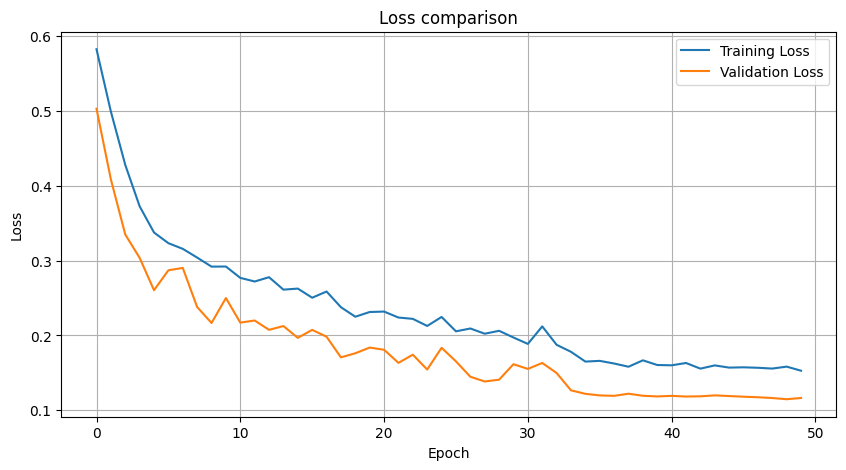

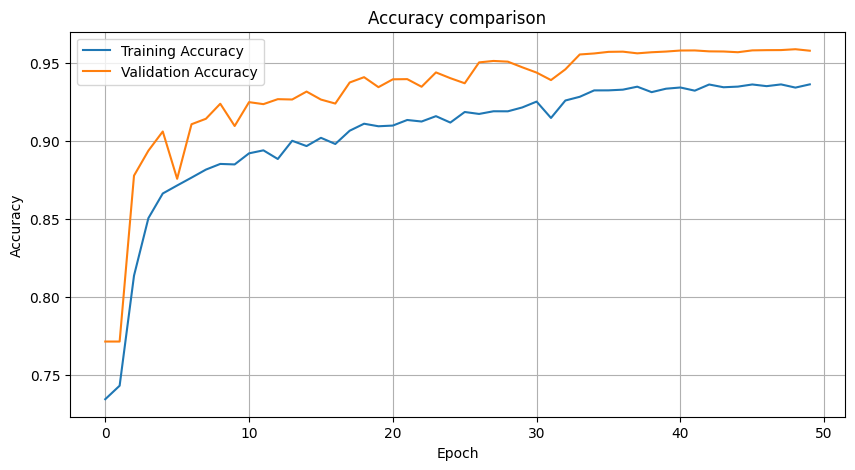

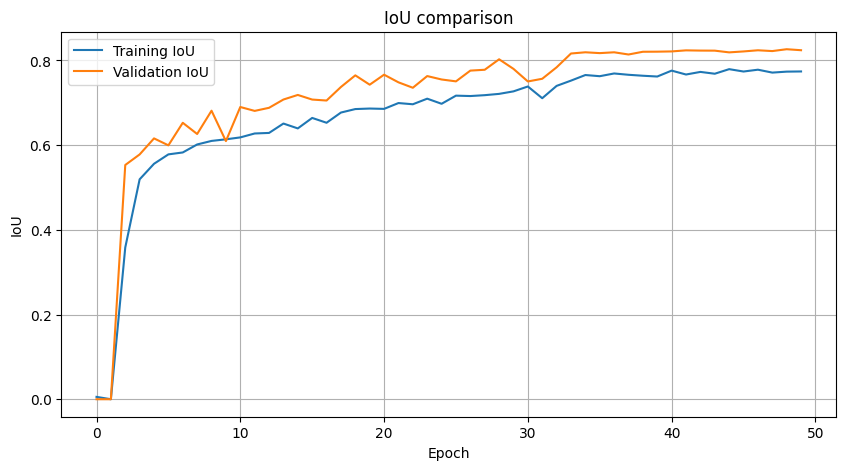

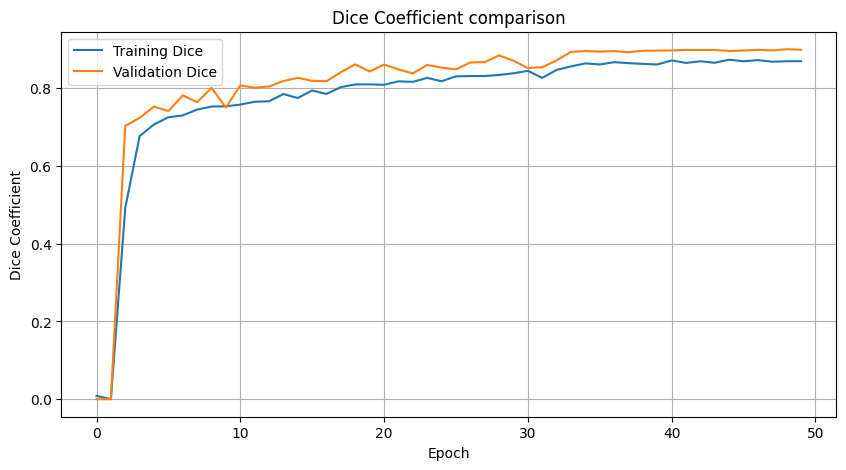

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title('Loss comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()
plt.figure(figsize=(10,5))
plt.plot(history.history['binary_iou_metric'], label='Training IoU')
plt.plot(history.history['val_binary_iou_metric'], label='Validation IoU')
plt.title('IoU comparison')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(history.history['dice_coefficient'], label='Training Dice')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice')
plt.title('Dice comparison')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True)
plt.show()

Što se tiče segmentacije, ovdje konkretno segmentacije soli, *loss* i *accuracy* nisu toliko bitni za nju, ali nam konstantno opadanje *loss* tokom treniranja i validacije i konstantan rast *accuracy* tokom treniranja i validacije što nam govori da model dobro generalizuje i da dobro uči i te metrike su se ustalile kroz kasnije epohe.  
Rast *IoU* i *Dice* kroz epohe je jako dobar znak što nam govori da model dobro prepoznava objekte i njegove granice i predviđa dobre maske kroz treniranje i validaciju. Ovdje možemo da vidimo da su validacioni *IoU* i *Dice* nešto veći kroz epohe nego trening *IoU* i *Dice* zato što model tokom treniranja uči sa augmentovanim podacima odnosno sa transformisanim slikama dok tokom validacije radi sa pravim slikama što je lakše i zato tu dava nešto bolje rezultate što je i normalno kada se koristi augmentacija.  
Model je dao najbolje rezultate u epohi 49 i taj model smo sačuvali kao *bestModel.keras* koji ćemo dalje koristiti za testiranje nad testnim podacima koje model prije nije gledao prilikom treniranja ili validacije. Ovdje je prikazano 20 nasumičnih rezultata od podataka koje smo sačuvali za testiranje.

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step


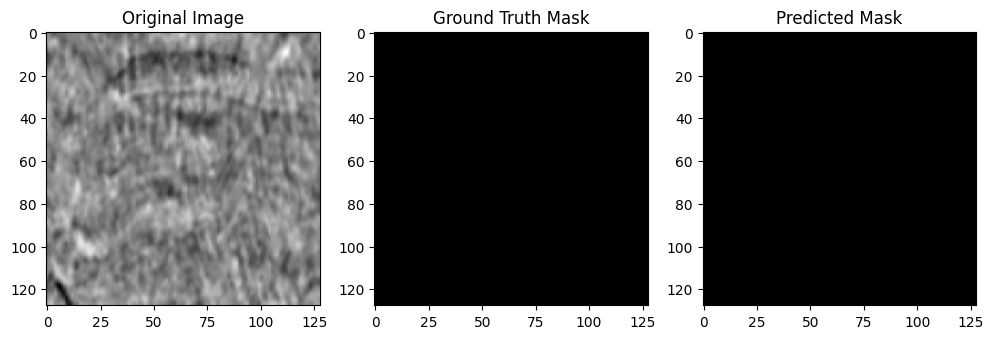

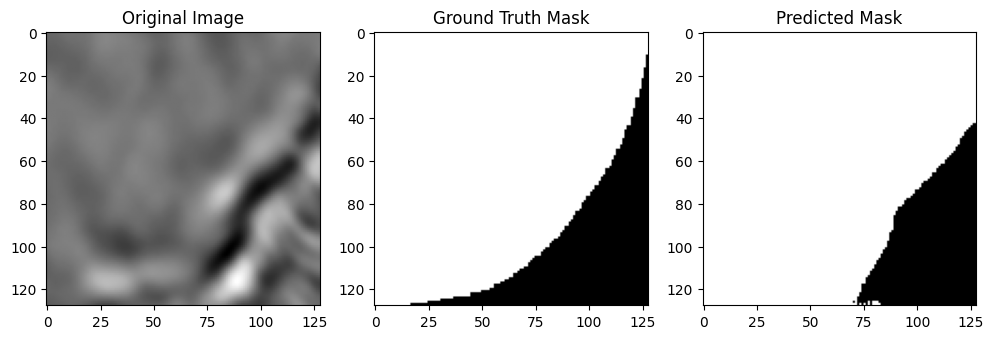

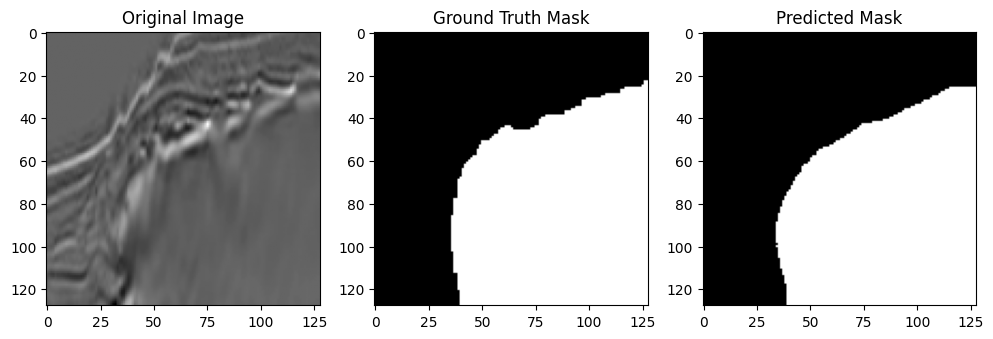

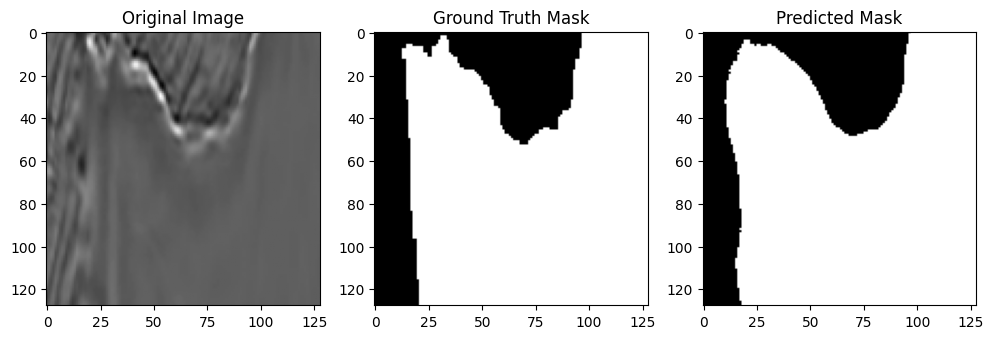

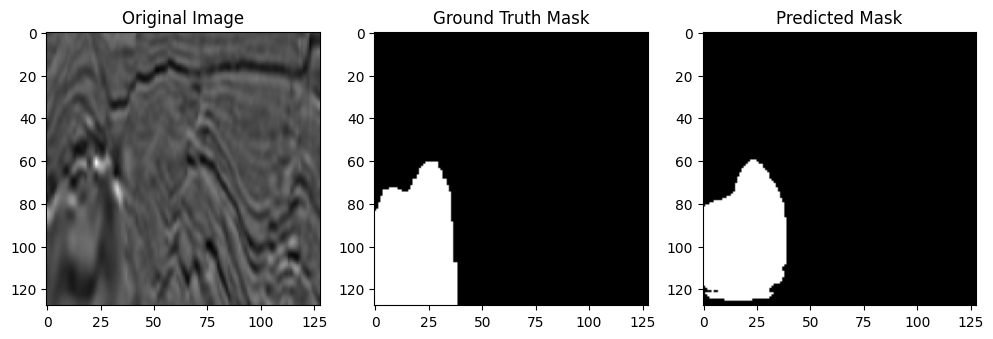

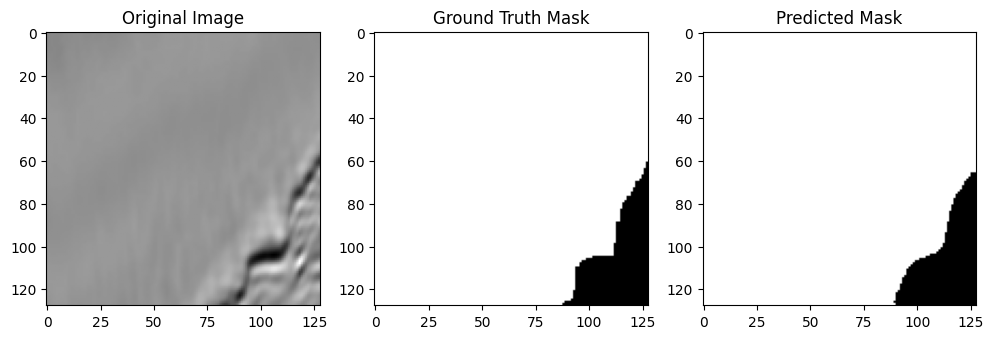

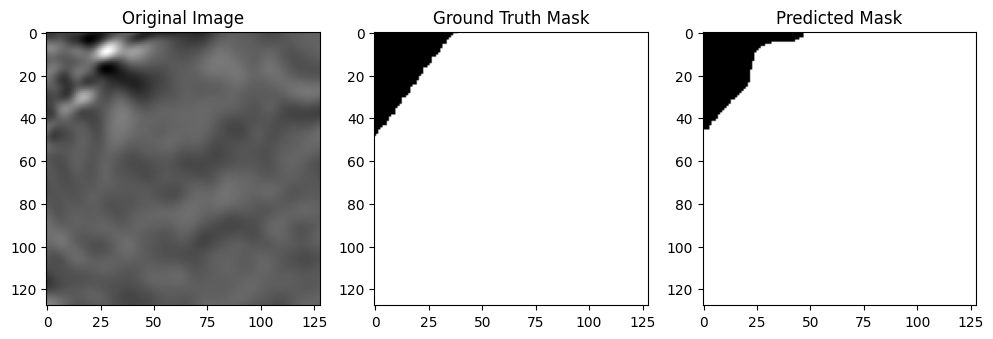

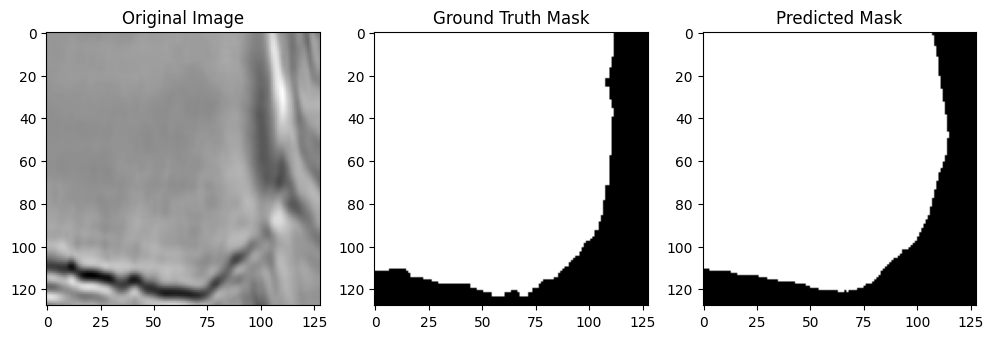

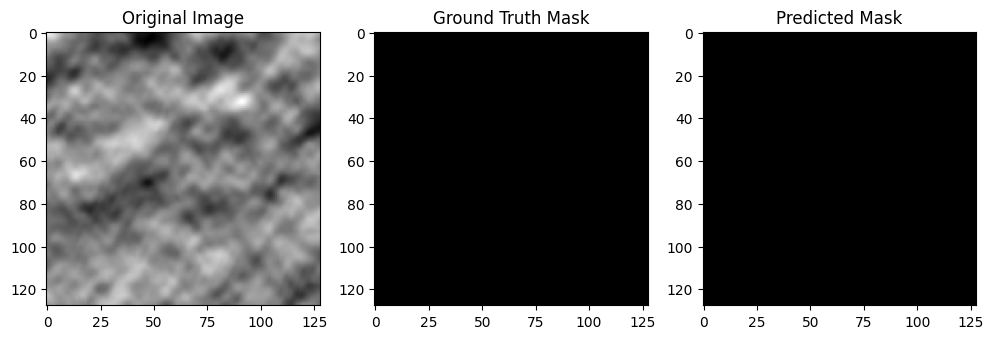

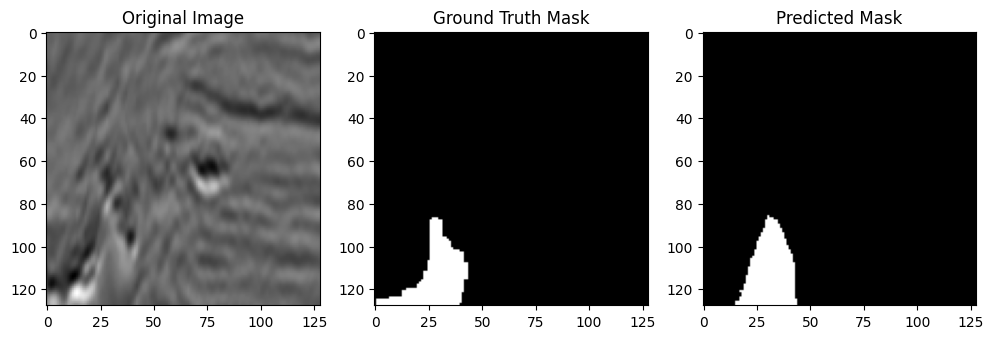

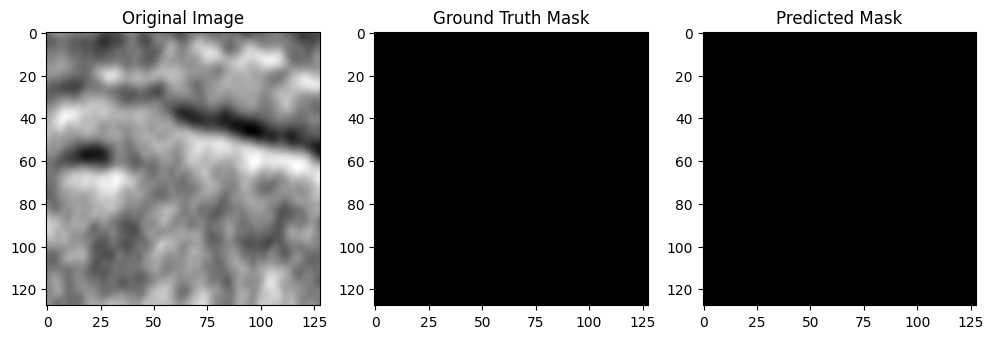

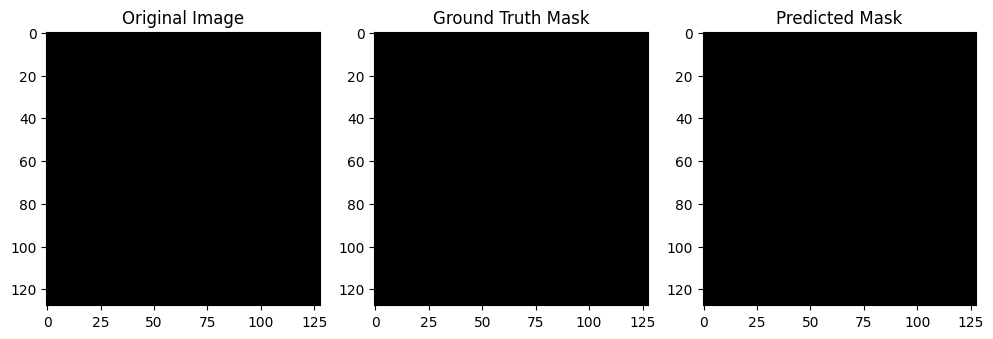

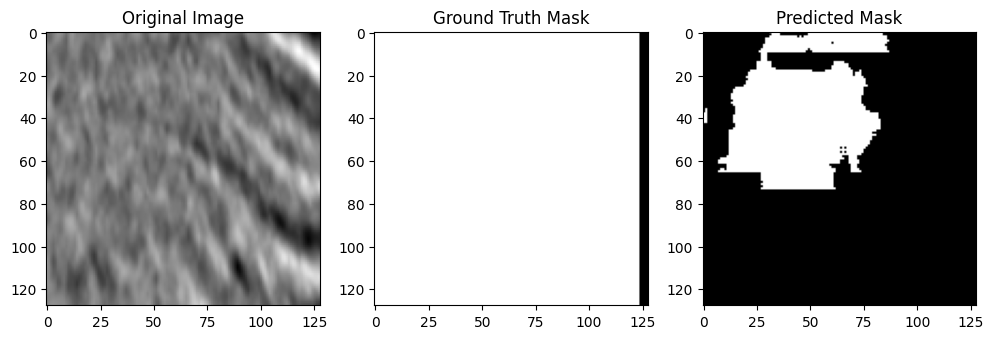

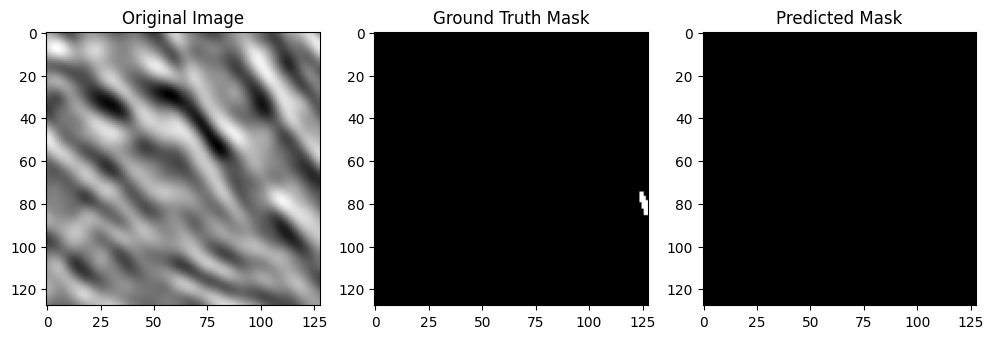

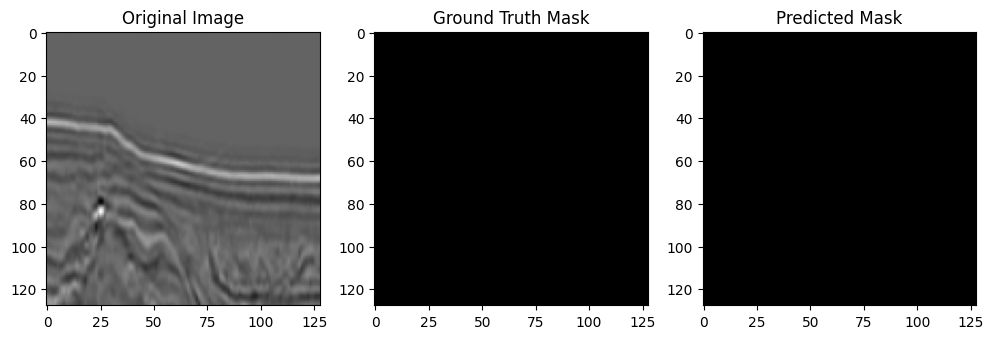

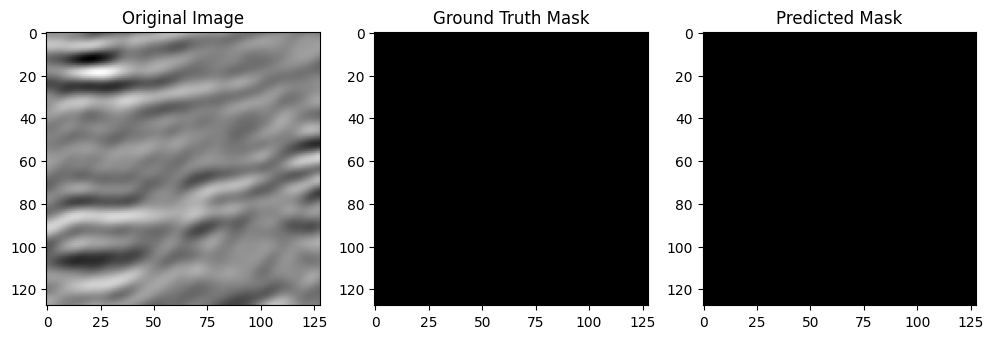

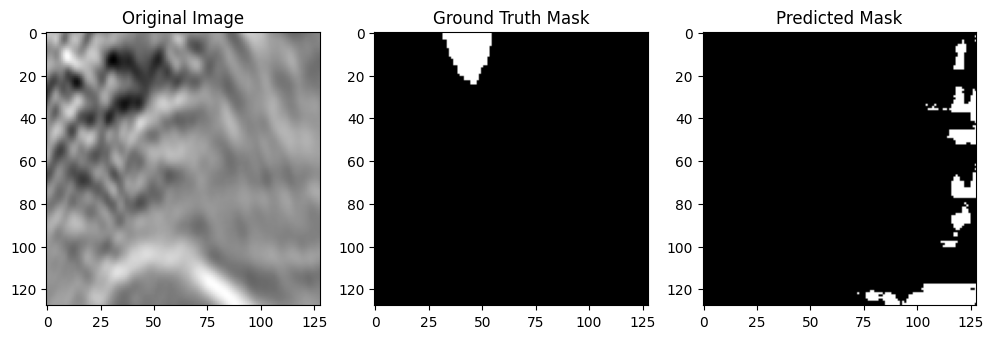

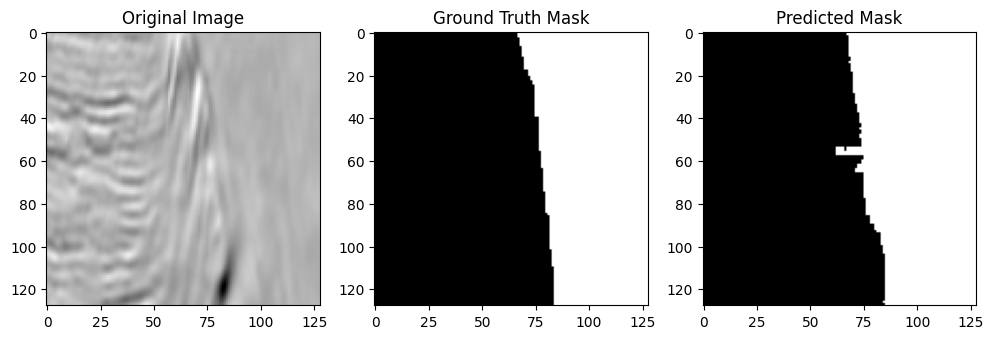

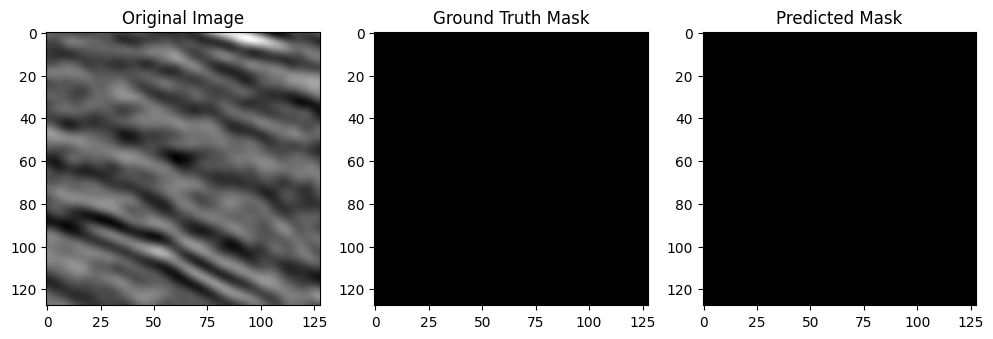

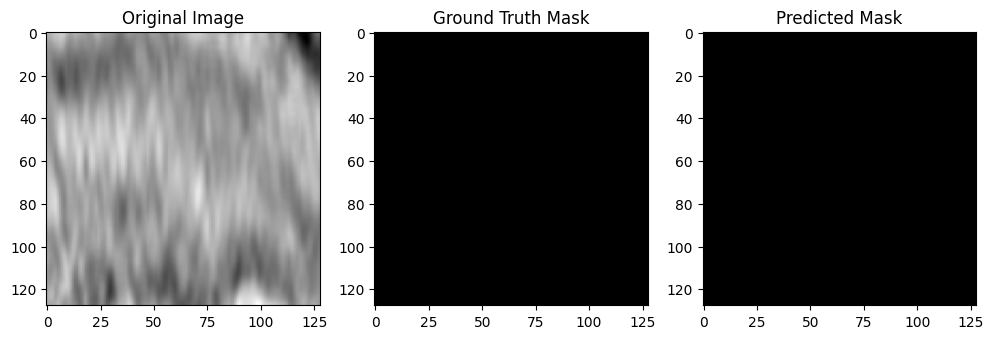

In [ ]:
from tensorflow.keras.models import load_model
model=load_model('/content/bestModel.keras', custom_objects={"dice_coefficient": dice_coefficient,
                      "binary_iou_metric": binary_iou_metric})
predsEval =model.predict(xEval, verbose=1)
nu = 20
random.seed(50)
randomIndex = random.sample(range(len(xEval)), nu)
for i in randomIndex:
  plt.figure(figsize=(12,4))
  plt.subplot(1,3,1)
  plt.imshow(xEval[i],cmap='gray')

  plt.title('Original Image')
  plt.subplot(1,3,2)
  plt.imshow(yEval[i], cmap='gray')

  plt.title('Ground Truth Mask')
  plt.subplot(1,3,3)
  plt.imshow(predsEval[i] > 0.5,cmap='gray')
  plt.title('Predisted Mask')
  plt.show

**Zaključak**

Ovaj model sa dobrim *IoU* i *Dice* ima prostora za napredak. Ovdje smo mogli za testiranje koristiti podatke iz *test.zip* foldera ali onda ne bi smo imali uvid u stvarne maske tih slika i ne bi bili sigurni da li je predviđena maska dobra ili ne i da podatke koje smo ovdje koristli za testiranje da koristimo za treniranje i validaciju. Takođe dataset sadrži dosta slika koje nemaju masku odnosno slike na kojima nema soli i to predstavlja dodatnu poteškoću za model da uči. Generalno veći dataset i testni podaci sa maskama i većina slika koja sadrže so mogu doprinijeti dodatnom poboljšanju ovoga modela.

**Izvori i literatura**



*   [U-Net with DICE and Augmentation](https://www.kaggle.com/code/kmader/u-net-with-dice-and-augmentation?utm_source=chatgpt.com)
*   [Image Segmentation - TensorFlow Core](https://www.tensorflow.org/tutorials/images/segmentation?utm_source=chatgpt.com)
*   [U-Net Image Segmentation in Keras](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/?utm_source=chatgpt.com)
*   [Image Augmentation on the fly using Keras ImageDataGenerator](https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/?utm_source=chatgpt.com)
*   [How to build a U-Net for image segmentation with TensorFlow and Keras](https://machinecurve.com/index.php/2022/01/30/how-to-build-a-u-net-for-image-segmentation-with-tensorflow-and-keras?utm_source=chatgpt.com)
*   [Image segmentation metrics](https://keras.io/api/metrics/segmentation_metrics/?utm_source=chatgpt.com)
*   Materijal sa vježbi za segmentaciju

